In [81]:
import torch
import numpy as np
from utils import init_C, Poisson_reg, log_stirling
import torch.linalg as TLA
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from VRA import SAGARAD, SAGRAD, SVRGRAD 

import time


from utils import build_block_Sigma, C_from_Sigma, sample_PLN, MSE



In [16]:
%load_ext autoreload

%autoreload 2

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else : 
    device = torch.device('cpu')
print('device ', device)

device  cpu


In [5]:
def sample_gaussians(N_samples, mean,sqrt_Sigma):
    '''
    samples some gaussians with the right mean and variance. Be careful, we ask 
    for the square root of Sigma, not Sigma. will detect automatically if we are using batches or not.  
    '''
    q = mean.shape[0]
    if len(mean.shape)> 1 : 
        q = mean.shape[1]
        W_orig = torch.randn(N_samples, 1,q,1).to(device)
    elif len(mean.shape) == 1 : 
        W_orig = torch.randn(N_samples, q, 1).to(device)
    W = torch.matmul(sqrt_Sigma.unsqueeze(0), W_orig).squeeze() + mean.unsqueeze(0)
    return W

def log_gaussian_density(W, mu_p,Sigma_p): 
    '''
    computes the log density of a gaussian
    '''
    dim = W.shape[-1]
    const = torch.sqrt((2*math.pi)**dim*torch.det(Sigma_p))
    Wmoinsmu = W-mu_p.unsqueeze(0)
    inv_Sig = torch.inverse(Sigma_p)
    if len(mu_p.shape)>1 : 
        log_d = -1/2*torch.matmul(torch.matmul(inv_Sig.unsqueeze(0), Wmoinsmu.unsqueeze(3)).squeeze().unsqueeze(2), Wmoinsmu.unsqueeze(3))
    elif len(mu_p.shape)== 1 :  
        log_d = -1/2*torch.matmul(Wmoinsmu.unsqueeze(1),torch.matmul(inv_Sig.unsqueeze(0), Wmoinsmu.unsqueeze(2))).squeeze()
    return log_d.squeeze() - torch.log(const)



def batch_log_P_WgivenY(Y_b, covariates_b, O_b, W, C, beta): 
    '''
    does the same as log_P_W_givenY but add one more dimension for computing this for a batch instead of 
    only one element. 
    '''
    length = len(W.shape)
    if length == 2 : 
        CW = torch.matmul(C.unsqueeze(0),W.unsqueeze(2)).squeeze()
    elif length == 3 : 
        CW = torch.matmul(C.unsqueeze(0).unsqueeze(1), W.unsqueeze(3)).squeeze()
    A_b = O_b + CW + covariates_b@beta
    return -q/2*math.log(2*math.pi)-1/2*torch.norm(W, dim = -1)**2 + torch.sum(-torch.exp(A_b)   + A_b*Y_b - log_stirling(Y_b) , axis = -1)



In [212]:
class IMPS_PLN():
    def __init__(self, q,average = 50):
        self.q = q
        self.average = average 
        self.running_times = list()
        self.log_likelihood_list = list()
        self.last_likelihoods = list()
        self.MSE_beta_list = list()
        self.MSE_Sigma_list = list()
        self.criteria_list = list()
        self.nb_iteration_list = list()
        self.cmpt = 0 
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
#         torch.manual_seed(0)
        self.fitted = False
        self.Y = Y.float().to(device)
        self.covariates = covariates.to(device)
        self.O = O.to(device)
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        self.starting_point = torch.zeros(self.n, self.q)
        noise = torch.randn(self.p) 
        self.last_betas = torch.zeros(self.average,self.d,self.p) # init of the average of the last betas
        self.last_Cs = torch.zeros(self.average, self.p, self.q) #init of the average of the last Sigmas
        
        # initialization for beta with a poisson regression 
        poiss_reg = Poisson_reg()
        poiss_reg.fit_torch(O,covariates,Y)
        self.beta = torch.clone(poiss_reg.beta.detach()).to(device)
        
        
        # init C with an array of size (p,q) taking the q vectors associated to 
        # the q largest eigenvectors of the estimated variance of log(Y)
        self.C = init_C(O, covariates, Y, self.beta, self.q).to(device)
                
        #setting some gradients for optimization. 
        self.C.requires_grad_(True)
        self.beta.requires_grad_(True)
        self.C_mean = torch.clone(self.C)
        self.beta_mean = torch.clone(self.beta)
        
    def get_batch(self,batch_size, save_batch_size = True): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always 0)
        '''
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        #if we want to set the batch size of the model to the given batch_size 
        if save_batch_size : 
            self.batch_size = batch_size
        # get the number of batches and the size of the last one. 
        nb_full_batch, last_batch_size  = self.n//batch_size, self.n % batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*batch_size: (i+1)*batch_size]], 
                    self.covariates[indices[i*batch_size: (i+1)*batch_size]],
                    self.O[indices[i*batch_size: (i+1)*batch_size]], 
                    indices[i*batch_size: (i+1)*batch_size]
                    ) 
        if last_batch_size != 0 : 
            if save_batch_size : 
                self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]],
                    indices[-last_batch_size:]
                    )
            
        

    def keep_records(self,log_like = torch.zeros(1)): 
        '''
        function that keep some records in order to plot the evolution after.
        '''
        average_log_like = self.average_params(log_like)
        self.running_times.append(time.time()-self.t0)
        self.MSE_beta_list.append(torch.mean((self.beta_mean -true_beta)**2).item())
        self.MSE_Sigma_list.append(torch.mean((self.C_mean@(self.C_mean.T) -true_Sigma_sampling)**2).item())
        self.log_likelihood_list.append(average_log_like)
    
    def average_params(self,log_like): 
        '''
        method that averages the parameters in order to smooth the variance. 
        We will take, for example, the last self.average betas computed to make 
        a better approximation of beta. We will do the same for C.
        This function adds the last parameters computed to update the mean of the parameter. 
        If we have not enough betas or Sigmas (less than self.average), the mean will be on those parameters. 
        args : 
            log_like : the likelihood computed with the current parameters.
        
        returns : 
                None but update the mean of the last self.average parameters.  
        '''
        
        self.cmpt +=1 # to keep track of the number of parameters we have for the mean
        # remove the oldest parameters and add the more recent one.
        self.last_betas[1:self.average] = torch.clone(self.last_betas[0: self.average-1].detach())
        self.last_betas[0] = torch.clone(self.beta.detach())
        self.last_Cs[1:self.average] = torch.clone(self.last_Cs[0: self.average-1].detach())
        self.last_Cs[0] = torch.clone(self.C.detach())
        self.last_likelihoods.append(log_like)
        # update the mean of the parameter
        
        # if we have enough parameters 
        if self.cmpt > self.average : 
            del(self.last_likelihoods[0])
            self.C_mean = torch.mean(self.last_Cs, axis = 0)
            self.beta_mean = torch.mean(self.last_betas, axis = 0)
            return np.mean(np.array(self.last_likelihoods))
        
        # if we don't have enough parameters. 
        else : 
            self.C_mean = torch.sum(self.last_Cs, axis = 0)/self.cmpt
            self.beta_mean = torch.sum(self.last_betas, axis = 0)/self.cmpt
            return np.mean(np.array(self.last_likelihoods))


    def fit(self, Y, O, covariates,  N_epoch, acc,lr,N_iter_mode, lr_mode, VR, batch_size = 10, class_optimizer = torch.optim.Rprop):
        '''
        fit the data. We infer p_theta with importance sampling and then use pytorch autodifferentiation
        '''
        self.t0 = time.time()
        self.batch_size = batch_size
        self.acc = acc
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        self.init_data(Y,O, covariates)# initialize the data. 
        self.optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        self.optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        if VR == 'SAGA' : 
            vr = SAGARAD([self.beta, self.C], self.n)
        elif VR == 'SAG': 
            vr = SAGRAD([self.beta, self.C], self.n)
        elif VR == 'SVRG': 
            vr = SVRGRAD([self.beta, self.C], self.n)
        else : 
            vr = None 
        self.log_like = -1000
        for j in tqdm(range(N_epoch)): 
            log_like = 0 
            for i, (Y_b, covariates_b, O_b, selected_indices) in enumerate(self.get_batch(batch_size)): 
                self.Y_b, self.covariates_b, self.O_b = Y_b.to(device), covariates_b.to(device), O_b.to(device)
                self.selected_indices = selected_indices
                log_like += self.infer_batch_p_theta(N_iter_mode, lr_mode, N_samples).item()
                batch_grad_C = - self.get_batch_grad_C()
                batch_grad_beta = - self.get_batch_grad_beta()
                if vr is not None : 
                    vr.update_new_grad([batch_grad_beta,batch_grad_C], selected_indices)
                else: 
                    self.beta.grad = torch.mean(batch_grad_beta, axis = 0)
                    self.C.grad = torch.mean(batch_grad_C, axis = 0)
                
                self.optim.step()
                self.optim.zero_grad()
                self.keep_records(self.log_like)
            self.log_like = log_like
            
                
            if VR == 'SVRG':
                self.Y_b, self.covariates_b, self.O_b = self.Y, self.covariates, self.O
                self.selected_indices = np.arange(0,self.n)
                self.get_gradient_requirement(N_iter_mode, lr_mode, N_samples)
                full_grad_C = -self.get_batch_grad_C()
                full_grad_beta = -self.get_batch_grad_beta()
                vr.update_table([full_grad_beta,full_grad_C])
            if j == 0 : 
                lr_mode/=10
            if j == 20 : 
                lr_mode/=3
            if j == 40 : 
                lr_mode/= 2
        self.fitted = True
                
                
        

    
    def infer_batch_p_theta(self, N_iter_mode, lr_mode, N_s,take_mean = True): 
        self.get_gradient_requirement(N_iter_mode, lr_mode, N_s)
        log = torch.log(torch.mean(self.weights,axis = 0))+self.const#*self.mask
        if take_mean :
            return torch.mean(log)
        else: 
            return log 
    
    def get_gradient_requirement(self, N_iter_mode, lr_mode, N_s):
        '''
        does all the operation that we need to compute the gradients. 
        We need the samples and the weights, that is what we compute here.
        '''
        #t = time.time()
        self.find_batch_mode(N_iter_mode, lr_mode)
        #print('time took mode ', time.time()- t)
        self.get_batch_best_var()
        self.samples = sample_gaussians(N_s, self.batch_mode, self.sqrt_Sigma_b)
        self.weights = self.get_batch_weights()
        
    def get_batch_weights(self): 
        self.log_f = self.batch_un_log_posterior(self.samples)
        self.log_g = log_gaussian_density(self.samples, self.batch_mode, self.Sigma_b)
        diff_log = self.log_f-self.log_g 
        self.const = torch.max(diff_log, axis = 0)[0]
        diff_log -= torch.max(diff_log, axis = 0)[0]
        weights = torch.exp(diff_log)
        return weights
    def get_batch_best_var(self):
        batch_matrix = torch.matmul(self.C.unsqueeze(2), self.C.unsqueeze(1)).unsqueeze(0)
        CW = torch.matmul(self.C.unsqueeze(0),self.batch_mode.unsqueeze(2)).squeeze()
        common = torch.exp(self.O_b  + self.covariates_b@self.beta + CW).unsqueeze(2).unsqueeze(3)
        prod = batch_matrix*common
        Hess_post = torch.sum(prod, axis = 1)+torch.eye(self.q).to(device) 
        self.Sigma_b = torch.inverse(Hess_post.detach())
        eps = torch.diag(torch.full((self.q,1),1e-8).squeeze()).to(device)
        self.sqrt_Sigma_b = TLA.cholesky(self.Sigma_b+ eps)
    def show_Sigma(self):
        sns.heatmap((self.C_mean@(self.C_mean.T)).detach().numpy())
        plt.show()
        
    def get_batch_grad_beta(self): 
        first = torch.matmul(self.covariates_b.unsqueeze(2), self.Y_b.unsqueeze(1).double())
        XB = torch.matmul(self.covariates_b.unsqueeze(1), self.beta.unsqueeze(0)).squeeze()
        CV = torch.matmul(self.C.reshape(1,1,self.p,1,self.q), self.samples.unsqueeze(2).unsqueeze(4)).squeeze()
        Xexp = torch.matmul(self.covariates_b.unsqueeze(0).unsqueeze(3), torch.exp(self.O_b + XB + CV).unsqueeze(2))
        sec = torch.sum(torch.multiply(self.weights.unsqueeze(2).unsqueeze(3), Xexp), axis = 0)/(torch.sum(self.weights, axis = 0).unsqueeze(1).unsqueeze(2))
        return first-sec
    
    def get_batch_grad_C(self): 
        XB = torch.matmul(self.covariates_b.unsqueeze(1), self.beta.unsqueeze(0)).squeeze()
        CV = torch.matmul(self.C.reshape(1,1,self.p,1,self.q), self.samples.unsqueeze(2).unsqueeze(4)).squeeze()
        Ymoinsexp = self.Y_b - torch.exp(self.O_b + XB + CV)
        outer = torch.matmul(Ymoinsexp.unsqueeze(3), self.samples.unsqueeze(2))
        denum = torch.sum(self.weights, axis = 0)
        num = torch.multiply(self.weights.unsqueeze(2).unsqueeze(3), outer)
        batch_grad = torch.sum(num/(denum.unsqueeze(0).unsqueeze(2).unsqueeze(3)), axis = 0)
        return batch_grad
    
    
    def find_batch_mode(self, N_iter, lr, eps = 7e-3):
        def batch_un_log_posterior(W): 
            return batch_log_P_WgivenY(self.Y_b, self.covariates_b, self.O_b, W, self.C, self.beta) 
        self.batch_un_log_posterior = batch_un_log_posterior
        W = torch.clone(self.starting_point[self.selected_indices].detach()).to(device)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        criterion = 2*eps
        old_W = torch.clone(W)
        i = 0
        keep_condition = True
        while  i < N_iter and keep_condition: 
            
            loss = -torch.mean(self.batch_un_log_posterior(W))
            loss.backward()
            optimizer.step()
            crit = torch.max(torch.abs(W-old_W))
            optimizer.zero_grad()
            if crit<eps and i > 2 : 
                keep_condition = False 
            old_W = torch.clone(W)
            i+= 1
        #print('nb iteration : ', i)
        self.nb_iteration_list.append(i)
        self.batch_mode = torch.clone(W)
        self.starting_point[self.selected_indices] = torch.clone(W)
        
    def show(self, save = False, name_graphic = ''): 
        '''
        function to show one model. It will plot the estimated log_likelihood in the y axis with the runtime 
        in the x-axis. 

        args : 
            'model' IMPS_PLN object where you have called model.fit_IMPS()
            'name_doss' : str. the name of the file you want to save the graphic. 
            'save' : bool. If True, the graphic will be saved. If false, won't be saved. 

        returns : 
                None but displays the figure. It can also save the figure if save = True. 
        '''
        if not self.fitted : 
            print('Please fit the model before, calling model.fit(Y,O,covariates)')
            return 

        else : 

            fig,ax = plt.subplots(3,1,figsize = (15,15))
            #log likelihood of the model. will also plot the log likelihood of the model with the true parameters. 
            abscisse = self.running_times
            ax[2].plot(abscisse, np.array(self.log_likelihood_list))
            ax[2].set_title('log likelihood')
            ax[2].set_ylabel('loglikelihood')
            ax[2].set_xlabel('Seconds')
            #variational_log_like = variational_model.compute_mean_log_likelihood(0.0001)[0].item()
            #ax[2].axhline(variational_log_like, c = 'black', label = 'variaitional likelihood')
            ax[2].set_yscale('symlog')
            ax[2].legend()
            
            
            ax[0].plot(abscisse, model.MSE_Sigma_list)
            ax[0].set_title(r'MSE $(\Sigma- \hat \Sigma)$')
            #ax[0].axhline(best_MSE_Sigma, label = 'MLE latent layer ', c = 'red', linestyle = '--')
            ax[0].set_xlabel('Seconds')
            ax[0].set_ylim(ymin= 1e-4)
            ax[0].set_ylabel('(a)')
            ax[0].set_yscale('log')

            #MSE of beta. 
            ax[1].plot(abscisse, model.MSE_beta_list)
            ax[1].set_title(r'MSE $(\beta - \hat \beta)$') 
            #ax[1].axhline(best_MSE_beta, label = 'MLE latent layer', c = 'red', linestyle = '--')
            ax[1].set_yscale('log')
            ax[1].set_ylim(ymin= 1e-4)
            ax[1].set_ylabel('(b)')
            ax[1].legend()
            
            if save : 
                plt.savefig(name_doss)
            plt.show()
            
    def Sigma(self): 
        return (self.C.detach())@(self.C.detach().T)
    
    def show_Sigma(self): 
        sns.heatmap(self.Sigma())

In [213]:
d = 3
n = 200;  p = 10
q = 4

In [214]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,p//4))/1.5 #+ 0.5*torch.eye(p)
true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))/3

covariates = torch.randn((n,d))
O =  0+torch.zeros((n,p))
sample_model = sample_PLN()
Y, Z, _  = sample_model.sample(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y).to(device)
covariates.to(device)
O.to(device)
None

In [218]:
batch_size = 20
model = IMPS_PLN(q, average = n//batch_size)
%time model.fit(Y,O,covariates,70, acc = 0.5,lr = 0.005,N_iter_mode = 2, lr_mode = 0.3,  class_optimizer = torch.optim.RMSprop, batch_size = batch_size,  VR ='SAGA')

100%|██████████| 70/70 [00:02<00:00, 26.64it/s]

CPU times: user 16.5 s, sys: 0 ns, total: 16.5 s
Wall time: 2.76 s


No handles with labels found to put in legend.
No handles with labels found to put in legend.


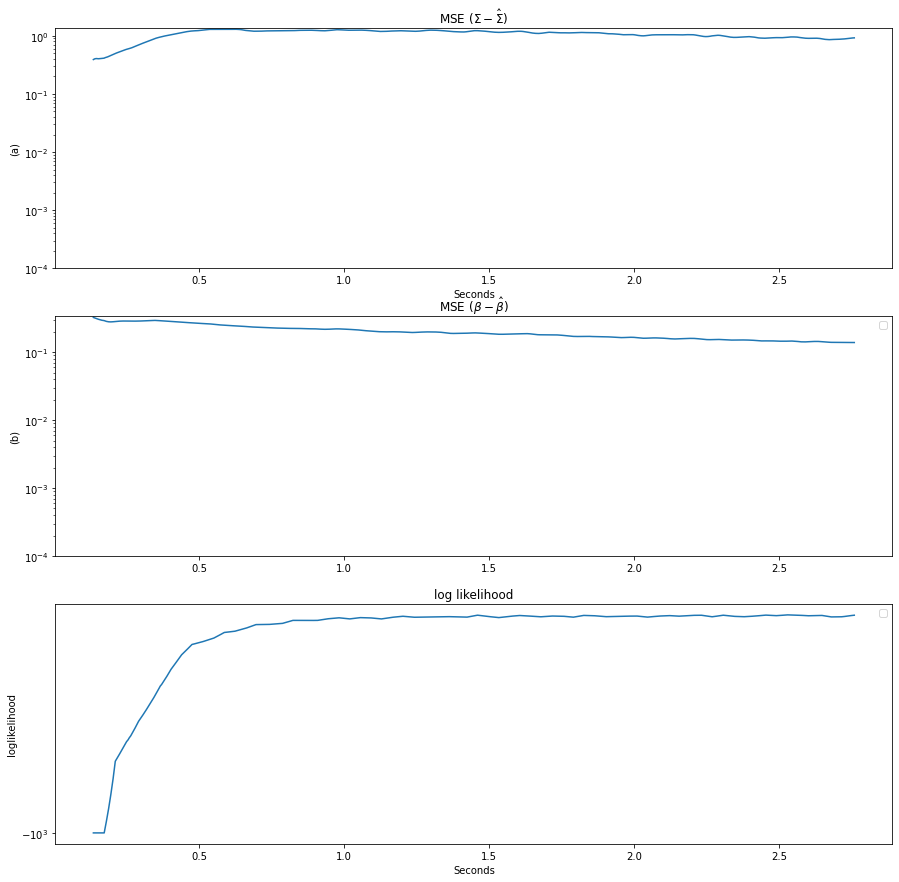

In [219]:
model.show()

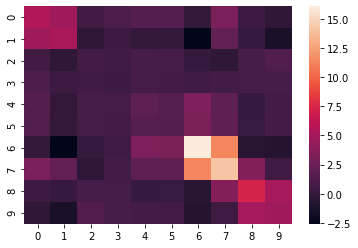

In [198]:
model.show_Sigma()

In [160]:
model.Sigma()

tensor([[ 2.6365,  1.5505,  1.6794,  ...,  1.1124,  1.5253,  0.9559],
        [ 1.5505,  1.7302,  1.5416,  ...,  0.5985,  0.3801, -0.2493],
        [ 1.6794,  1.5416,  2.0789,  ...,  0.6295,  0.5450, -0.2631],
        ...,
        [ 1.1124,  0.5985,  0.6295,  ...,  4.9951,  5.1933,  3.5472],
        [ 1.5253,  0.3801,  0.5450,  ...,  5.1933,  7.6110,  5.9044],
        [ 0.9559, -0.2493, -0.2631,  ...,  3.5472,  5.9044,  5.8972]])

In [161]:
true_Sigma_sampling

tensor([[ 6.9380e-01,  8.5376e-01,  9.6648e-01,  ..., -6.0520e-05,
         -6.9422e-05, -6.3675e-05],
        [ 8.5376e-01,  1.0510e+00,  1.1906e+00,  ..., -7.1670e-05,
         -8.2223e-05, -7.5422e-05],
        [ 9.6648e-01,  1.1906e+00,  1.3509e+00,  ..., -7.5112e-05,
         -8.6191e-05, -7.9071e-05],
        ...,
        [-6.0520e-05, -7.1670e-05, -7.5112e-05,  ...,  2.6729e+00,
          2.4612e+00,  2.0417e+00],
        [-6.9422e-05, -8.2223e-05, -8.6191e-05,  ...,  2.4612e+00,
          2.2826e+00,  1.9004e+00],
        [-6.3675e-05, -7.5422e-05, -7.9071e-05,  ...,  2.0417e+00,
          1.9004e+00,  1.5853e+00]])

<AxesSubplot:>

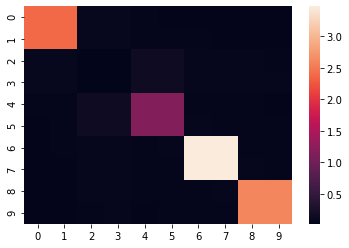

In [195]:
sns.heatmap(true_Sigma_sampling)

In [133]:
MSE(model.Sigma()-true_Sigma_sampling)

tensor(0.3035)

In [114]:
MSE(model.Sigma()-true_Sigma_sampling)

tensor(0.0297)

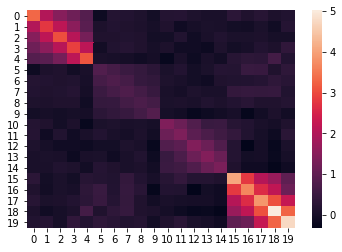

In [115]:
model.show_Sigma()